# Espectros de variância, covariância e correlação

### Implementação com vetorização 

por [Afrânio](http://afrjr.weebly.com) - LMSCP - Laboratório de Modelagem, Simulação e Controle de Processos - PEQ/COPPE/UFRJ

11/2018

Neste notebook, é explicada em detalhes a implementação do cálculo dos espectros de variância, covariância e correlação de forma otimizada utilizando conceitos de vetorização. A linguagem de programação utilizada é a [Python 3.6](https://www.python.org/) e a vetorização se baseia em recursos da biblioteca [NumPy](http://www.numpy.org/).

Atenção: A classe **spectra** aqui implementada está totalmente funcional, mas pode não estar em sua última versão. Para a versão mais recente, checar o módulo *spectra.py* presente no repositório https://github.com/afraeq/spectra.

In [1]:
# importando todos os módulos necessários

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Broadcasting

A base da construção das janelas móveis para o cálculo dos espectros está no conceito de [broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html), que diz respeito a como o [NumPy](http://www.numpy.org/) trata matrizes de dimensões diferentes em operações aritméticas. 

Quando o [NumPy](http://www.numpy.org/) realiza uma operação aritmética entre duas matrizes, ele compara as dimensões de seus eixos, começando pelo final e indo até o primeiro eixo da matriz menor, de modo a verificar a compatibilidade entre elas. Dois eixos são ditos compatíveis se:

* *suas dimensões são iguais*. Nesse caso, a operação entre os eixos é realizada intuitivamente, elemento a elemento. 
* *uma das dimensões é 1*. Nesse caso, os elementos do eixo com dimensão 1 são repetidos $n$ vezes, sendo $n$ a dimensão do outro eixo. É como se o eixo de dimensão 1 fosse "esticado" de modo a ficar do mesmo tamanho do eixo de dimensão $n$. Isso ocorre, por exemplo, quando multiplicamos um escalar por um vetor:

In [2]:
a = 2
b = np.array([0,1,2,3])
a*b

array([0, 2, 4, 6])

Realizar a operação acima implica em um [broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html): o objeto **a**, de dimensão 1, é "esticado" para ficar do mesmo tamanho que **b**, de dimensão 4. A operação equivalente seria:

In [3]:
a = np.array([2,2,2,2])
b = np.array([0,1,2,3])
a*b

array([0, 2, 4, 6])

Apesar da equivalência, no primeiro caso a operação se dá de forma muito mais eficiente.

### Usando broadcasting para construir janelas móveis

Construiremos aqui, de forma vetorizada, janelas móveis que percorrem matrizes de dados usando o [broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html). A abordagem é baseada em https://stackoverflow.com/questions/39232790.

A matriz usada como exemplo será:

In [4]:
arr = np.random.randn(6,3)
arr

array([[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
       [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01],
       [ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
       [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00],
       [ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
       [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]])

Para criar uma janela deslizante, definimos os parâmetros **WS** (tamanho da janela, ou *window size*) e **NW** (número de janelas, ou *number of windows*):

In [5]:
WS = 2
NW = arr.shape[0]-WS+1 # essa fórmula de NW é específica para janelas deslizantes!

* Passo 1: criar uma matriz de formato **(NW,1)**:

In [6]:
idx_1 = np.arange(NW)[:,np.newaxis]
idx_1

array([[0],
       [1],
       [2],
       [3],
       [4]])

O **np.newaxis** dentro dos colchetes é necessário para que o formato resultante seja **(NW,1)** e não **(NW,)**.

* Passo 2: criar um vetor de dimensão **WS**:

In [7]:
idx_2 = np.arange(WS)
idx_2

array([0, 1])

O pulo do gato aqui está no [broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html) que ocorre quando soma-se **idx_1** com **idx_2**:

In [8]:
idx = idx_1 + idx_2
idx

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5]])

A soma se dá entre matrizes de formatos **(5,1)** e **(2,)**. O resultado é a duplicação dos elementos da matriz **idx_1** para se adequar à dimensão do último eixo de **idx_2**. Sendo assim, o resultado **idx** tem formato **(5,2)**.

A matriz **idx** pode ser usada como índice da matriz **arr**:

In [9]:
janelas = arr[idx]
janelas

array([[[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
        [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01]],

       [[-1.20242460e-01,  4.86217705e-04,  2.60542438e-01],
        [ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01]],

       [[ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
        [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00]],

       [[ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00],
        [ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00]],

       [[ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
        [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]]])

In [10]:
janelas.shape

(5, 2, 3)

Quase como passe de mágica, estão criadas nossas janelas móveis! Calculadas de forma eficiente, vetorizada e sem loops.

Na matriz 3d acima, tem-se os seguintes eixos:

* 0: correspondente às várias janelas, de dimensão 5;
* 1: correspondente aos pontos (observações) em cada janela, de dimensão 2;
* 2: correspondente às variáveis, de dimensão 3.

A seguir, temos exemplos concretos de indexação dessa matriz 3d de modo a selecionar algumas porções de interesse.

Selecionando a primeira janela:

In [11]:
janelas[0,:,:]

array([[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
       [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01]])

Selecionando a segunda observação de cada uma das janelas:

In [12]:
janelas[:,1,:]

array([[-1.20242460e-01,  4.86217705e-04,  2.60542438e-01],
       [ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
       [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00],
       [ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
       [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]])

Selecionando a terceira variável de cada uma das janelas:

In [13]:
janelas[:,:,2]

array([[-1.73420409,  0.26054244],
       [ 0.26054244, -0.29866645],
       [-0.29866645, -1.3913615 ],
       [-1.3913615 ,  1.44703418],
       [ 1.44703418, -0.90307381]])

Selecionando a primeira observação das duas últimas variáveis em cada uma das três primeiras janelas:

In [14]:
janelas[0:3,0,-2:]

array([[-1.50303231e+00, -1.73420409e+00],
       [ 4.86217705e-04,  2.60542438e-01],
       [ 7.60189332e-01, -2.98666451e-01]])

### Usando broadcasting para construir janelas móveis - generalização do cálculo

Abaixo, tem-se uma função lambda que condensa os cálculos para criação da matriz dos índices que geram a matriz 3d de janelas:

In [15]:
idx = lambda n_rows,WS,d: (d*np.arange((n_rows-WS+1)/d)[:,None].astype(int) + np.arange(WS))

O parâmetro $d$ indica o grau de acoplamento entre as janelas. Se $d=1$, tem-se as chamadas janelas deslizantes (ou adjuntas). Se $d=WS$, tem-se as janelas independentes (ou disjuntas).

Por exemplo, para o caso de janelas deslizantes de tamanho 2:

In [16]:
arr[idx(arr.shape[0],2,1)]

array([[[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
        [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01]],

       [[-1.20242460e-01,  4.86217705e-04,  2.60542438e-01],
        [ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01]],

       [[ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
        [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00]],

       [[ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00],
        [ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00]],

       [[ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
        [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]]])

Já para o caso de janelas independentes de tamanho 2:

In [17]:
arr[idx(arr.shape[0],2,2)]

array([[[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
        [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01]],

       [[ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
        [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00]],

       [[ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
        [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]]])

### Calculando espectros de variância

Usaremos a mesma matriz-exemplo:

In [18]:
janelas

array([[[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
        [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01]],

       [[-1.20242460e-01,  4.86217705e-04,  2.60542438e-01],
        [ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01]],

       [[ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
        [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00]],

       [[ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00],
        [ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00]],

       [[ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
        [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]]])

Calculando as variâncias ao longo do eixo 1 (correspondente às observações em cada janela):

In [19]:
var = np.var(janelas,ddof=1,axis=1)
var

array([[0.45942362, 1.13028398, 1.98950685],
       [0.91438843, 0.28857441, 0.15635729],
       [0.0633325 , 0.13779033, 0.59699123],
       [0.1062647 , 0.05052117, 4.02824501],
       [5.60854138, 0.15507051, 2.76150378]])

Calculando as médias das variâncias em todas as janelas:

In [20]:
%%time
var_spctr_mean = np.mean(var,axis=0)

CPU times: user 115 µs, sys: 1e+03 ns, total: 116 µs
Wall time: 126 µs


In [21]:
var_spctr_mean

array([1.43039013, 0.35244808, 1.90652083])

Esses são os pontos dos espectros de variância de cada variável correspondentes ao tamanho de janela **WS** = 2. Para calcular os espectros inteiros, basta variar WS até o valor **arr.shape[0]+1 ** (no caso de janelas deslizantes) ou **int(arr.shape[0]/2+1)** (no caso de janelas independentes).

As médias podem ser calculadas de forma ligeiramente mais eficiente usando a [soma de Einsten](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.einsum.html):

In [22]:
%%time
var_spctr_mean = np.einsum('ij->j',var)/janelas.shape[0]

CPU times: user 64 µs, sys: 13 µs, total: 77 µs
Wall time: 82 µs


In [23]:
var_spctr_mean

array([1.43039013, 0.35244808, 1.90652083])

Para mais detalhes sobre a soma de Einsten, consultar o excelente post: https://stackoverflow.com/questions/26089893.

### Calculando espectros de covariância e correlação

A abordagem dessa seção é baseada em https://stackoverflow.com/questions/40394775.

Para entender melhor o cálculo da matriz de covariância, consultar https://stattrek.com/matrix-algebra/covariance-matrix.aspx.
 
Usaremos a mesma matriz-exemplo:

In [24]:
janelas

array([[[ 8.38322742e-01, -1.50303231e+00, -1.73420409e+00],
        [-1.20242460e-01,  4.86217705e-04,  2.60542438e-01]],

       [[-1.20242460e-01,  4.86217705e-04,  2.60542438e-01],
        [ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01]],

       [[ 1.23208031e+00,  7.60189332e-01, -2.98666451e-01],
        [ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00]],

       [[ 1.58798057e+00,  2.35231562e-01, -1.39136150e+00],
        [ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00]],

       [[ 1.12697145e+00, -8.26400137e-02,  1.44703418e+00],
        [-2.22221991e+00,  4.74263050e-01, -9.03073807e-01]]])

A seguinte função, **calc_cov**, aceita uma matriz tridimensional de janelas, estruturada como a matriz acima, e retorna uma matriz tridimensional com a mesma estrutura, contendo no eixo 1 as matrizes de covariância de cada janela.

In [25]:
def calc_cov(x):
    x = x - x.sum(axis=1,keepdims=True)/x.shape[1]
    return np.einsum('ijk,ijl->ikl',x,x)/(x.shape[1] - 1)

Explicando a função **calc_cov**:

* Na primeira linha, a matriz de entrada é transformada em uma matriz de desvios em relação às médias das observações em cada janela. 

* Na segunda linha, é calculada a matriz tridimensional contendo as matrizes de covariância propriamente ditas, compostas pelas somas dos quadrados e produtos cruzados das observações em cada janela. É importante observar que o segundo eixo das matrizes de entrada da soma de Einsten (representado por **j** e referente ao eixo 1, ou seja, às observações em cada janela) não aparece na matriz de saída, ou seja, não aparece após a seta. Isso significa que a soma é efetuada ao longo desse eixo, que, portanto, não está presente no produto final.

Usando a função:

In [26]:
Sxx = calc_cov(janelas)
Sxx

array([[[ 0.45942362, -0.72061027, -0.9560473 ],
        [-0.72061027,  1.13028398,  1.49956918],
        [-0.9560473 ,  1.49956918,  1.98950685]],

       [[ 0.91438843,  0.51368191, -0.37811546],
        [ 0.51368191,  0.28857441, -0.21241637],
        [-0.37811546, -0.21241637,  0.15635729]],

       [[ 0.0633325 , -0.0934163 , -0.19444523],
        [-0.0934163 ,  0.13779033,  0.28680938],
        [-0.19444523,  0.28680938,  0.59699123]],

       [[ 0.1062647 ,  0.07327085, -0.65426315],
        [ 0.07327085,  0.05052117, -0.45112265],
        [-0.65426315, -0.45112265,  4.02824501]],

       [[ 5.60854138, -0.93258746,  3.93548069],
        [-0.93258746,  0.15507051, -0.65439117],
        [ 3.93548069, -0.65439117,  2.76150378]]])

In [27]:
Sxx.shape

(5, 3, 3)

In [28]:
# à título de comparação
janelas.shape

(5, 2, 3)

O eixo 0 de **Sxx** continua correspondendo às janelas, assim como na matriz-exemplo **janelas**. Já os eixos 1 e 2 compõem, conjuntamente, as matrizes de covariância. Portanto, ambos devem ter a mesma dimensão que o eixo 2 da matriz-exemplo, que corresponde às variáveis.

Calculando as médias dos elementos correspondentes das diversas matrizes de covariância:

In [29]:
%%time
Sxx_mean = np.mean(Sxx,axis=0)
Sxx_mean

CPU times: user 84 µs, sys: 1e+03 ns, total: 85 µs
Wall time: 90.8 µs


In [30]:
Sxx_mean

array([[ 1.43039013, -0.23193226,  0.35052191],
       [-0.23193226,  0.35244808,  0.09368967],
       [ 0.35052191,  0.09368967,  1.90652083]])

In [31]:
%%time
Sxx_mean = np.einsum('ijk->jk',Sxx)/janelas.shape[0]
Sxx_mean

CPU times: user 76 µs, sys: 6 µs, total: 82 µs
Wall time: 167 µs


In [32]:
Sxx_mean

array([[ 1.43039013, -0.23193226,  0.35052191],
       [-0.23193226,  0.35244808,  0.09368967],
       [ 0.35052191,  0.09368967,  1.90652083]])

Novamente, percebe-se que a soma de Einsten é mais eficiente.

Esses são os pontos dos espectros de variância de cada variável e covariância de cada combinação de variáveis correspondentes ao tamanho de janela **WS** = 2. Novamente, para calcular os espectros inteiros, basta variar WS até o valor **arr.shape[0]+1 ** (no caso de janelas deslizantes) ou **int(arr.shape[0]/2+1)** (no caso de janelas independentes).

Para calcular as médias das matrizes de correlação a partir de **Sxx_mean**, basta fazer:

In [33]:
%%time
Dinv = np.linalg.inv(np.diag(np.sqrt(np.diag(Sxx_mean))))
r_xx_mean = Dinv@Sxx_mean@Dinv

CPU times: user 158 ms, sys: 7.15 ms, total: 165 ms
Wall time: 166 ms


In [34]:
r_xx_mean

array([[ 1.        , -0.32665276,  0.2122595 ],
       [-0.32665276,  1.        ,  0.11429398],
       [ 0.2122595 ,  0.11429398,  1.        ]])

Portanto, calcular o espectro de correlação a partir do espectro de covariância mostra-se trivial.

### Classe espectra

Na classe abaixo, os cálculos demonstrados são encapsulados e estendidos.

In [35]:
class spectra (object):

    #########################
    
    def __init__ (self,data):
               
        data = np.asarray(data)
            
        if data.ndim==1:
            self.data = data[:,np.newaxis]
        elif data.ndim==2:
                self.data = data
        else:
            raise ValueError('Entry must have 1 or 2 dimensions!')
        
        self.var_spctr   = {}
        self.cov_spctr   = {}
        self.corr_spctr  = {}
        self.l_var_spctr = {}
        
        self.jump_WS_var   = {}
        self.jump_WS_cov   = {}
        self.jump_WS_l_var = {}
        
        kinds = ['sliding','independent']
        
        for kind in kinds:       
            self.var_spctr   [kind] = {}
            self.cov_spctr   [kind] = {}
            self.corr_spctr  [kind] = {}
            self.l_var_spctr [kind] = {}

        self.spctr_size = {}            
        self.spctr_size['sliding']     = self.data.shape[0]+1
        self.spctr_size['independent'] = int(self.data.shape[0]/2+1)
        
        # https://stackoverflow.com/questions/39232790
        self.idx = lambda WS,d: \
        (d*np.arange((self.data.shape[0]-WS+1)/d)[:,None].astype(int) + \
        np.arange(WS))

        self.d = {}
        self.d['sliding']     = lambda WS: 1
        self.d['independent'] = lambda WS: WS
        
    #########################
                
    def calc_Var_Spectra (self, kind='sliding', jump_WS=1):
        
        self.jump_WS_var[kind] = jump_WS
                
        spctr_size = self.spctr_size[kind]
                        
        var_spctr_mean = np.zeros((spctr_size,self.data.shape[1]))
        var_spctr_median = np.zeros((spctr_size,self.data.shape[1]))
        
        for WS in range(2,spctr_size,jump_WS):
            win = self.data[self.idx(WS,self.d[kind](WS))]
            var = np.var(win,ddof=1,axis=1)
            var_spctr_mean[WS,:]   = np.mean(var,axis=0)
            var_spctr_median[WS,:] = np.median(var,axis=0)
                                
        self.var_spctr[kind]['mean']   = var_spctr_mean                                             
        self.var_spctr[kind]['median'] = var_spctr_median

    ################################################ 
    
    def calc_Cov_Spectra (self, kind='sliding', jump_WS=1):
        
        self.jump_WS_cov[kind] = jump_WS
        
        spctr_size = self.spctr_size[kind]
        
        cov_spctr_mean  = np.zeros((spctr_size,self.data.shape[1],
                                    self.data.shape[1]))
        corr_spctr_mean = np.zeros((spctr_size,self.data.shape[1],
                                    self.data.shape[1]))
                
        # https://stackoverflow.com/questions/26089893
        # https://stackoverflow.com/questions/40394775
        
        for WS in range(2,spctr_size,jump_WS):  
            win = self.data[self.idx(WS,self.d[kind](WS))]
            m1 = win - win.sum(axis=1,keepdims=True)/win.shape[1]
            Sxx = np.einsum('ijk,ijl->ikl',m1,m1)/(win.shape[1] - 1)
            Sxx_mean = np.einsum('ijk->jk',Sxx)/win.shape[0]
            cov_spctr_mean[WS,:,:] = Sxx_mean
            Dinv = np.linalg.inv(np.diag(np.sqrt(np.diag(Sxx_mean))))
            corr_spctr_mean[WS,:,:] = Dinv@Sxx_mean@Dinv
            
        self.cov_spctr[kind]['mean']  = cov_spctr_mean
        self.corr_spctr[kind]['mean'] = corr_spctr_mean

    #########################   
    
    def calc_Lat_Var_Spectra (self, kind='sliding',jump_WS=1):
        
        self.jump_WS_l_var[kind] = jump_WS
        
        from sklearn.preprocessing import scale
        data = scale(self.data)

        spctr_size = self.spctr_size[kind]
        
        l_var_spctr_mean = np.zeros((spctr_size,data.shape[1]))
                
        for WS in range(data.shape[1],spctr_size,jump_WS):  
            win = data[self.idx(WS,self.d[kind](WS))]
            m1 = win - win.sum(axis=1,keepdims=True)/win.shape[1]
            Sxx = np.einsum('ijk,ijl->ikl',m1,m1)/(win.shape[1] - 1)
            Sxx_mean = np.einsum('ijk->jk',Sxx)/win.shape[0]
            _, L, _ = np.linalg.svd(Sxx_mean)
            l_var_spctr_mean[WS,:] = L
            
        self.l_var_spctr[kind]['mean'] = l_var_spctr_mean
        
    #########################   

    def plot_Var_Spectra(self,i=None,ax=None,mean_or_median='mean'):
        
        if i==None:
            i= np.arange(self.data.shape[1])
        if ax == None:
            ax = plt.gca() 
        if self.var_spctr['sliding']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['sliding'],
                              self.jump_WS_var['sliding']),
                    self.var_spctr['sliding']
                                  [mean_or_median]
                                  [2::self.jump_WS_var['sliding'],i])
        if self.var_spctr['independent']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['independent'],
                              self.jump_WS_var['independent']),
                    self.var_spctr['independent']
                                  [mean_or_median]
                                  [2::self.jump_WS_var['independent'],i],'.')
        ax.set_xlabel('Window size')
        ax.set_ylabel('$\sigma^2$')
        ax.set_xticks(list(ax.get_xticks()) + [2])
        ax.margins(0);
        
    ######################### 
    
    def plot_Cov_Spectra(self,i,j,ax=None,
                         mean_or_median='mean',
                         corr_or_cov='corr'):

        if ax == None:
            ax = plt.gca()        
            
        if corr_or_cov == 'corr':
            spctr = self.corr_spctr
            ylabel='$r_{ij}$'
        elif corr_or_cov == 'cov':
            spctr = self.cov_spctr
            ylabel='$\sigma_{ij}^2$'    
            
        if spctr['sliding']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['sliding'],
                              self.jump_WS_cov['sliding']),
                    spctr['sliding'][mean_or_median]
                         [2::self.jump_WS_cov['sliding'],i,j])
        if spctr['independent']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['independent'],
                              self.jump_WS_cov['independent']),
                    spctr['independent'][mean_or_median]
                         [2::self.jump_WS_cov['independent'],i,j],'.')
        ax.set_xticks(list(ax.get_xticks()) + [2])
        ax.set_xlabel('Window size')
        ax.set_ylabel(ylabel)
        ax.margins(0);
        
    ######################### 
    
    def plot_Lat_Var_Spectra(self,ax=None,mean_or_median='mean'):
        
        if ax == None:
            ax = plt.gca() 
        
        if self.l_var_spctr['independent']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(self.data.shape[1],
                              self.spctr_size['independent'],
                              self.jump_WS_l_var['independent']),
                    self.l_var_spctr['independent']
                                    [mean_or_median]
                                    [self.data.shape[1]::
                                     self.jump_WS_l_var['independent']],'.')
        if self.l_var_spctr['sliding']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(self.data.shape[1],
                              self.spctr_size['sliding'],
                              self.jump_WS_l_var['sliding']),
                    self.l_var_spctr['sliding']
                                    [mean_or_median]
                                    [self.data.shape[1]::
                                     self.jump_WS_l_var['sliding']])            
        ax.set_xticks(list(ax.get_xticks()) + [self.data.shape[1]])
        ax.set_xlabel('Window size')
        ax.set_ylabel('$\lambda_i$')
        ax.margins(0);

Por exemplo, calculando o espectro de variância de um sinal senoidal:

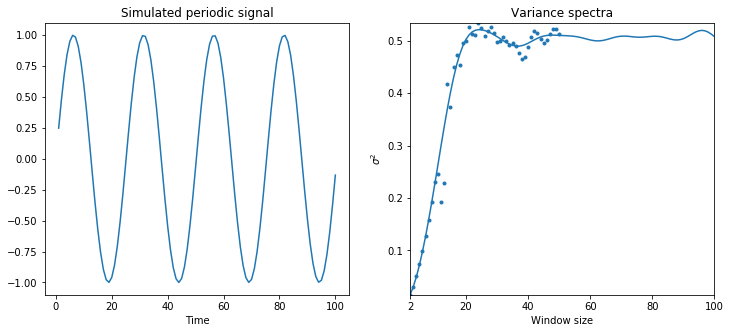

In [36]:
t1 = np.arange(1,101)
sinal1 = np.sin(t1/4)

# creating example 1 instance
test1 = spectra(sinal1)

# calculating example 1 spectrum, with sliding windows
test1.calc_Var_Spectra('sliding')

# calculating example 1 spectrum, with independent windows
test1.calc_Var_Spectra('independent')

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(t1,sinal1)
test1.plot_Var_Spectra(ax=ax[1])

ax[0].set_xlabel('Time')

ax[0].set_title('Simulated periodic signal');
ax[1].set_title('Variance spectra');

Para mais exemplos, checar o notebook referente à apresentaçã geral do método, disponível no repositório https://github.com/afraeq/spectra.

## Referência

[Thiago Feital e José Carlos Pinto - Use of variance spectra for in-line validation of process measurements in continuous processes - The Canadian Journal of Chemical Engineering - 2015. DOI: 10.1002/cjce.22219.](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)